In [6]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from itertools import cycle
from tqdm.auto import trange

from matplotlib import cm
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from utils import plot as plot_utils, s3w as s3w_utils, vmf as vmf_utils, misc as utils
from utils.nf import normalizing_flows
from methods import s3wd as s3w, sswd as ssw, swd as sw

from scipy.stats import gaussian_kde

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

In [7]:
def run_exp(X_target, X0, model, d_func, d_args, device, n_steps=2000, lr=1e-3, batch_size=500, snapshot_t=None):
    """
    Runs experiments using a Normalizing Flow model.
    Args:
    - X_target (torch.Tensor): Target distribution tensor.
    - X0 (torch.Tensor): Initial state of particles.
    - model (torch.nn.Module): Normalizing Flow model.
    - optimizer (torch.optim.Optimizer): Optimizer for the model.
    - d_func (function): Distance function.
    - d_args (dict): Arguments for the distance function.
    - device (torch.device): Device.
    - n_steps (int): Number of gradient steps.
    - lr (float): Learning rate.
    - batch_size (int): Batch size for processing.
    Returns:
    - List of tensors representing the state of particles at each step.
    - List of loss values.
    """

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    dataset = TensorDataset(X_target)
    dataiter = cycle(DataLoader(dataset, batch_size=batch_size, shuffle=True))

    X0 = X0.to(device)
    X0.requires_grad_(True)

    L = [X0.clone()]
    L_loss = []
    pbar = trange(n_steps)

    saved_snapshots = {}

    for k in pbar:
        X_target_batch = next(dataiter)[0].type(torch.float).to(device)

        optimizer.zero_grad()

        z, _ = model(X0)

        distance = d_func(z[-1], X_target_batch, **d_args)
        distance.backward()

        optimizer.step()

        with torch.no_grad():
            X0 = F.normalize(X0, p=2, dim=1)

        L_loss.append(distance.item())
        L.append(X0.clone().detach())
        pbar.set_postfix_str(f"Loss = {distance.item():.3f}")

        if snapshot_t is not None:
            if k in snapshot_t:
                noise = F.normalize(torch.randn((1000, 3), device=device), p=2, dim=-1)
                z0, _ = model(noise)
                saved_snapshots[k] = z0[-1].detach().cpu().numpy()

    if snapshot_t: return L, L_loss, saved_snapshots
    return L, L_loss

## Acknowledgement: Adapted from Bonet et al. 2023 (https://github.com/clbonet/spherical_sliced-wasserstein)

In [8]:
mu_target = [0, 1, 0]
mu_target = mu_target / np.linalg.norm(mu_target)
kappa_target = 10
X_target = torch.tensor(vmf_utils.rand_vmf(mu_target, kappa=kappa_target, N=1000), dtype=torch.float)

X0 = torch.randn((500, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)

model = normalizing_flows.make_NF(d=3, n_blocks=6, n_components=5, device=device)

d_func = s3w.s3wd
d_args = {'n_projs': 1000, 'device': device, 'p': 2}

L, L_loss, snapshots = run_exp(X_target, X0, model, d_func, d_args, device=device, n_steps=2000,lr=1e-1, batch_size=500, snapshot_t=[0,500,1000,1500,1999])

  0%|          | 0/2000 [00:00<?, ?it/s]

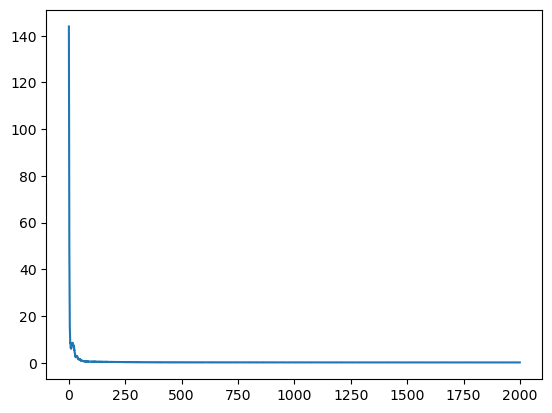

In [9]:
plt.plot(L_loss)
plt.show()

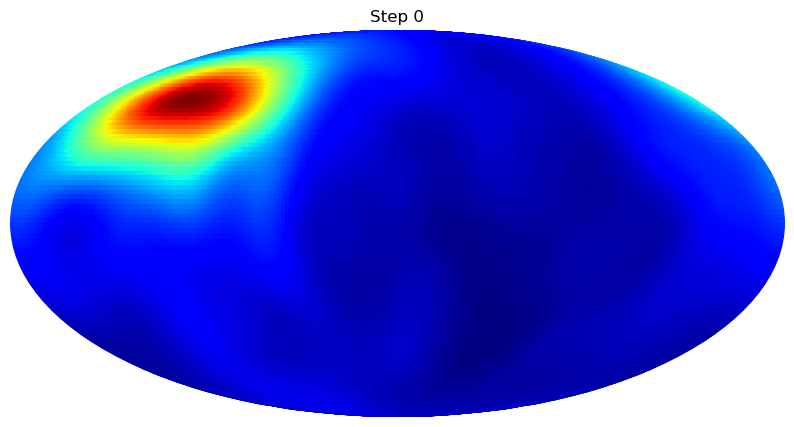

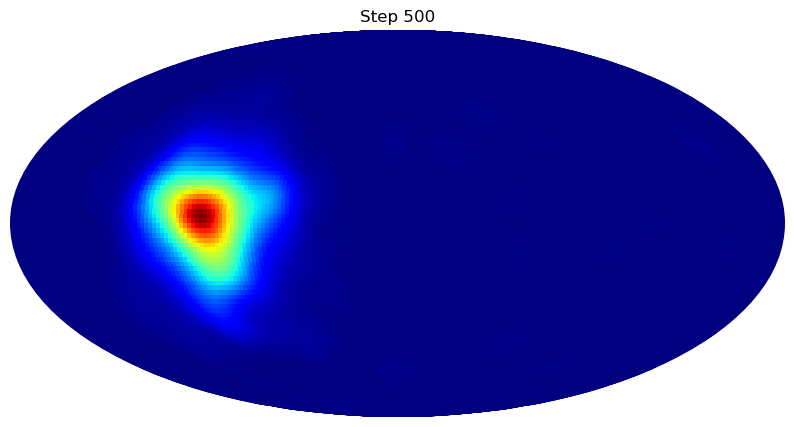

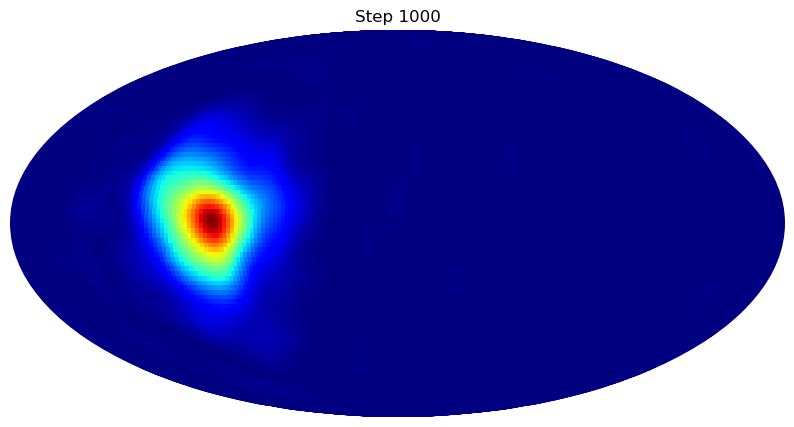

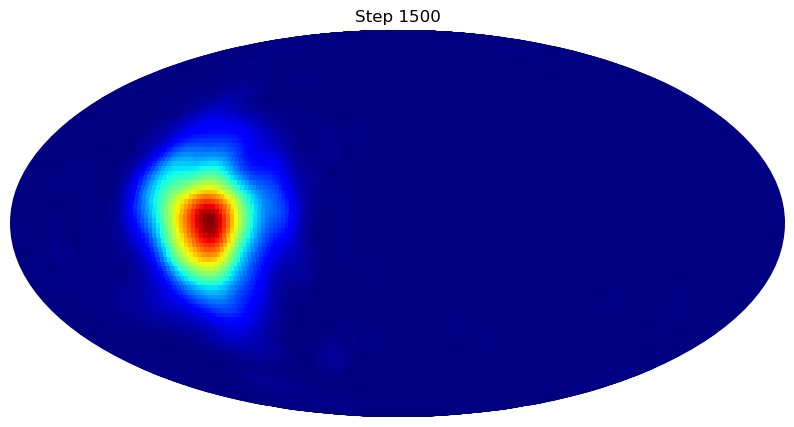

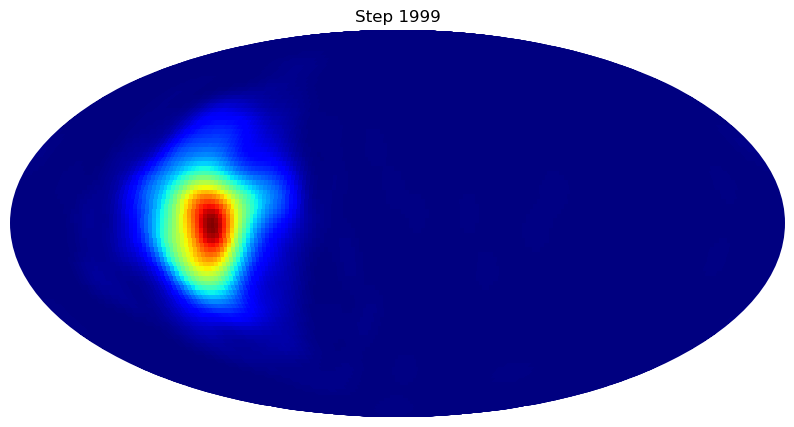

In [10]:
for step, output in snapshots.items():
    kernel = gaussian_kde(output.T)

    def density_function(x):
        return kernel.pdf(x.T)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': "mollweide"})
    plot_utils.projection_mollweide(density_function, ax)
    ax.set_title(f"Step {step}")
    plt.show()

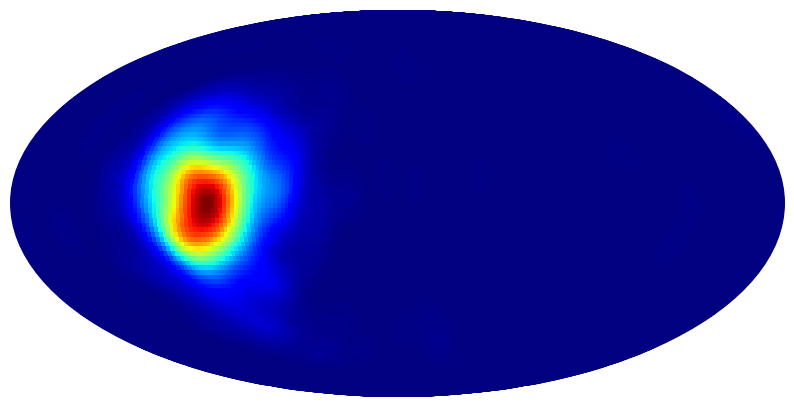

In [11]:
noise = F.normalize(torch.randn((1000,3), device=device), p=2, dim=-1)
z0, _ = model(noise)

kernel = gaussian_kde(z0[-1].T.detach().cpu())

fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
plot_utils.projection_mollweide(lambda x: kernel.pdf(x.T), ax)
plt.show()

In [12]:
model = normalizing_flows.make_NF(d=3, n_blocks=6, n_components=5, device=device)

d_func = ssw.sswd
d_args = {'num_projections': 1000, 'device': device, 'p': 2}

L, L_loss, snapshots = run_exp(X_target, X0, model, d_func, d_args, device=device, n_steps=2000,lr=1e-1, batch_size=500, snapshot_t=[0,500,1000,1500,1999])

  0%|          | 0/2000 [00:00<?, ?it/s]

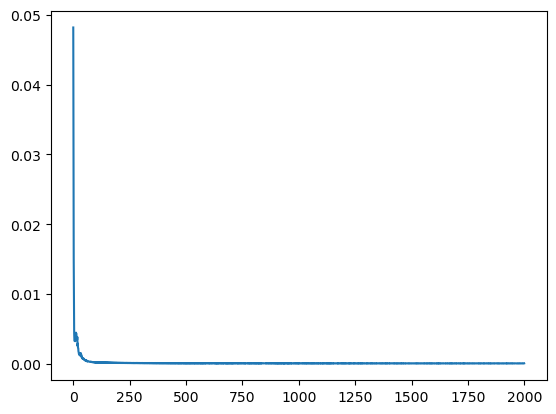

In [13]:
plt.plot(L_loss)
plt.show()

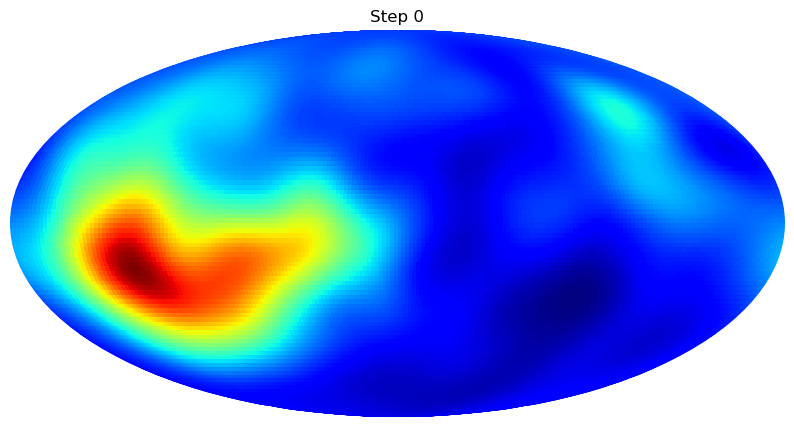

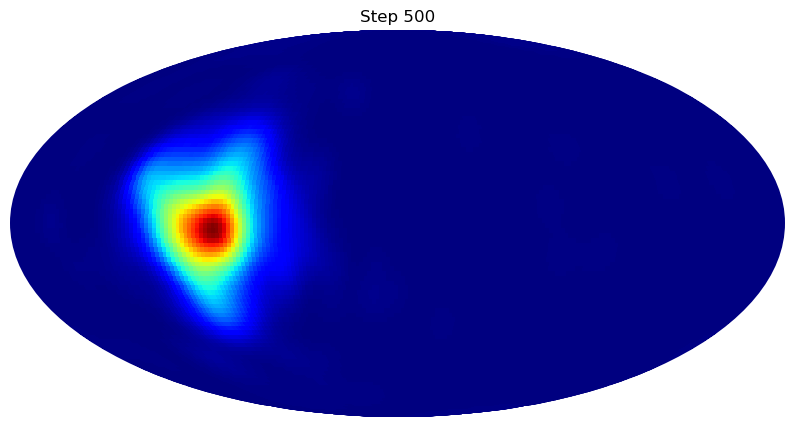

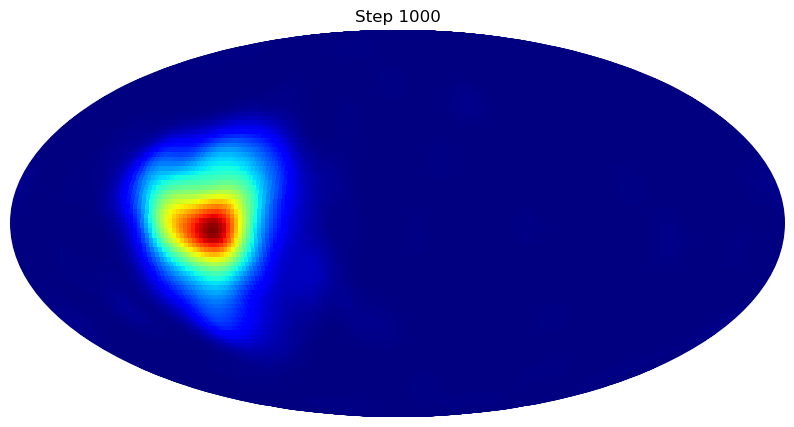

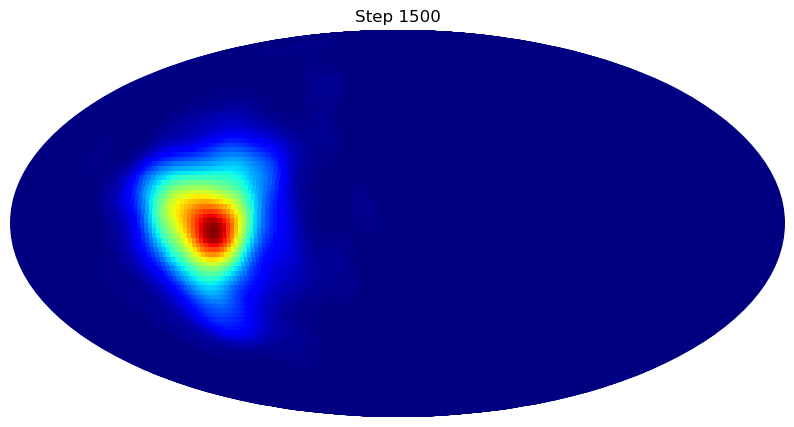

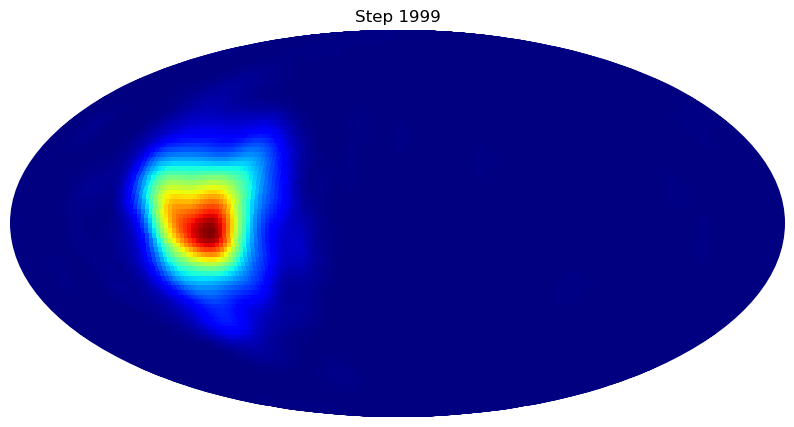

In [14]:
for step, output in snapshots.items():
    kernel = gaussian_kde(output.T)

    def density_function(x):
        return kernel.pdf(x.T)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': "mollweide"})
    plot_utils.projection_mollweide(density_function, ax)
    ax.set_title(f"Step {step}")
    plt.show()